In [11]:
# Discards the output of the cell
%%capture

# To work with youtube videos
!pip install pafy youtube-dl moviepy

In [22]:
# libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
# set Numpy, Python and Tensorflow seeds to get consistent results on every execution
# restricting the randomness
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
# Discards the output of the cell
%%capture

# Downloading the UCF50 Action dataset from the web
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the dataset
!unrar x UCF50.rar

## **Visualizing the dataset**

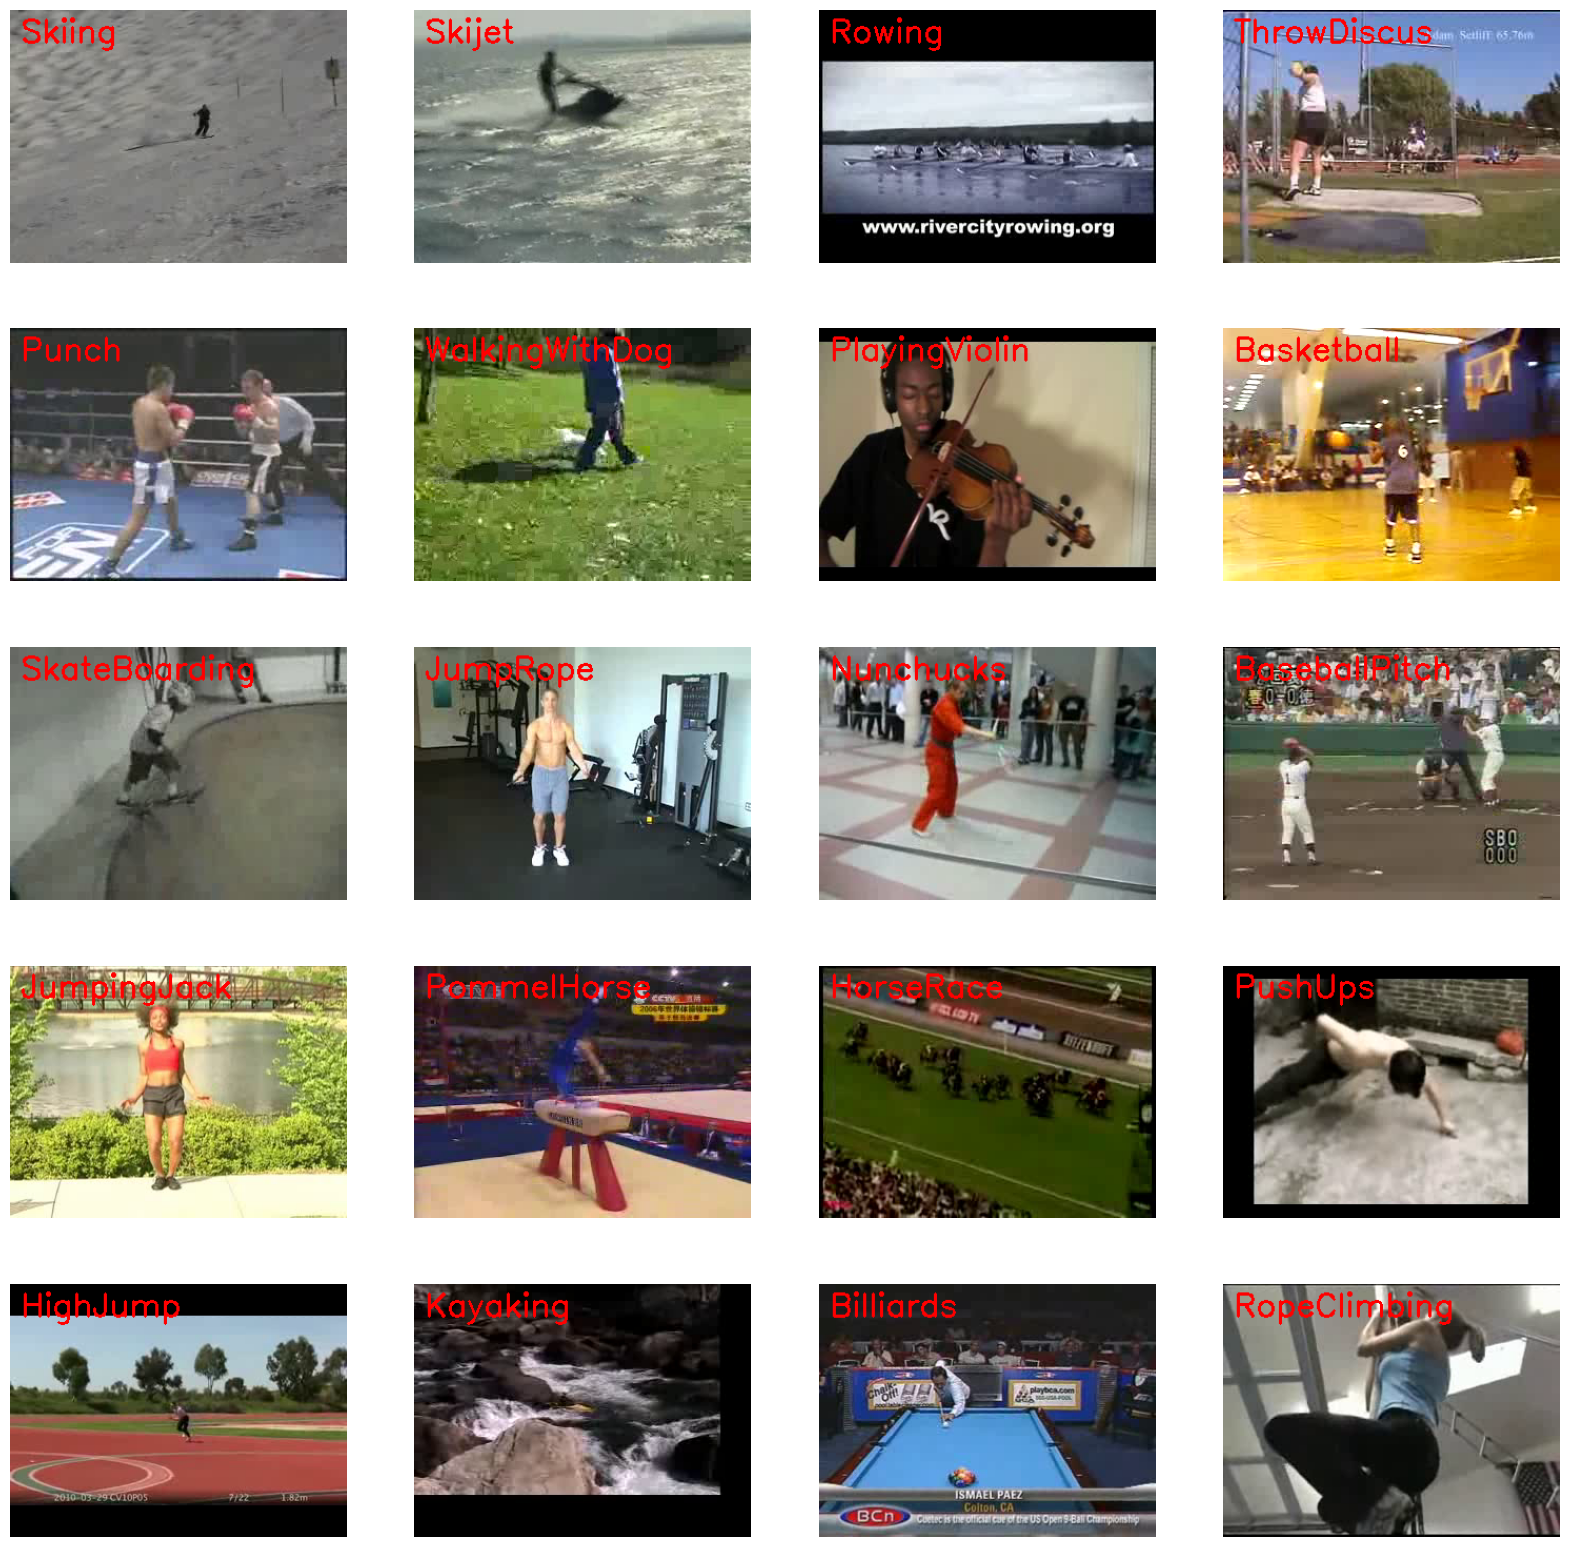

In [8]:
# create and specify size of matplot figure
plt.figure(figsize = (20, 20))

# get names of all action categories
all_classes_names = os.listdir('UCF50')

# get 20 random categories
random_range = random.sample(range(len(all_classes_names)), 20)

# iterate through all the generated random values
for counter, random_index in enumerate(random_range, 1):

    # get the name of the random category
    selected_class_Name = all_classes_names[random_index]

    # get the list of all the video files present in selected_class_Name
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # randomly select a video file from the list
    selected_video_file_name = random.choice(video_files_names_list)

    # video capture object to read the video file
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # release the video capture object
    video_reader.release()

    # convert the frame from BGR into RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # write the class name on the video frame (USED TO WRITE ON THE VIDEO)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # display the frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Preprocess the data

In [9]:
from re import I
# resizing the video frames in our dataset
img_height, img_width = 64, 64

# specify the number of frames of a video that will be fed to the model as one sequence
sequence_length = 20

# specifying the dataset directory
dataset_dir = "UCF50"

# Specifying the list of classes used for training the model
classes_list = ["PullUps", "BenchPress", "Punch", "PlayingGuitar", "PushUps"]

## Function to Extract , Resize and Normalize the frames

In [12]:
# function extracts the required frame from the video after resizing and normalizing it and then returns the a list of resized and normalized frames
def frame_extraction(video_path):
  frames_list = []

  # reading the video file using the VideoCapture object
  video_reader = cv2.VideoCapture(video_path)

  # counting the total number of frames in the video file
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # calculating the interval after which frames will be added
  skip_frames_window = max(int(video_frames_count/sequence_length), 1)

  # iterate through the video frames
  for frame_counter in range(sequence_length):
    # set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # read a frame from the video
    success, frame = video_reader.read()

    # check if the frame is not successfully read
    if not success:
      break

    # resize the frame
    resized_frame = cv2.resize(frame, (img_height, img_width))

    # normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    # append the normalized frame into the frames list
    frames_list.append(normalized_frame)

  # release the video capture object
  video_reader.release()

  # return the frames list
  return frames_list

In [13]:
# Function for dataset creation
'''
this function returns:
  features: a list containing extracted frames of videos
  labels: a list containing the corresponding labels of the extracted frames
  video_files_paths: a list containing the paths of the videos from which the frames were extracted
'''


def create_dataset():
  features = []
  labels = []
  video_files_paths = []

  # iterating through all the classes mentioned in the class list
  for class_index, class_name in enumerate(classes_list):

    # Display name of the class
    print(f'Extracting data from class: {class_name}')

    # get the list of video files present in the class
    files_list = os.listdir(os.path.join(dataset_dir, class_name))

    # iterate through all the files present in the files list
    for file_name in files_list:

      # get the video file path
      video_file_path = os.path.join(dataset_dir, class_name, file_name)

      # extract the frames from the video file
      frames = frame_extraction(video_file_path)

      # check if the extracted frames is equal to the sequence length i.e. 20
      # ignore videos having frames less than 20
      if len(frames) == sequence_length:

        # append the data
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # convert the features and labels lists to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)

  # return the features, labels and video files paths
  return features, labels, video_files_paths




## creating the required dataset

In [14]:
features, labels, video_files_paths = create_dataset()

Extracting data from class: PullUps
Extracting data from class: BenchPress
Extracting data from class: Punch
Extracting data from class: PlayingGuitar
Extracting data from class: PushUps


In [15]:
# converting class indexes (labels) into one-hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# it helps in processing the data faster, it converts the interger data to binary 0, 1

In [16]:
# Splitting data into train and test set
# data for training 75%
# data for testing 25%

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# Long-term Reccurence Convolutional Network Model

In [17]:
def create_LRCN_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'), input_shape = (sequence_length, img_height, img_width, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(classes_list), activation = 'softmax'))

  model.summary()

  return model


In [18]:
# Constructing model
LRCN_model = create_LRCN_model()
print("Model Created Successfully")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 2, 2, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,093 (285.52 KB)

 Trainable params: 73,093 (285.52 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully


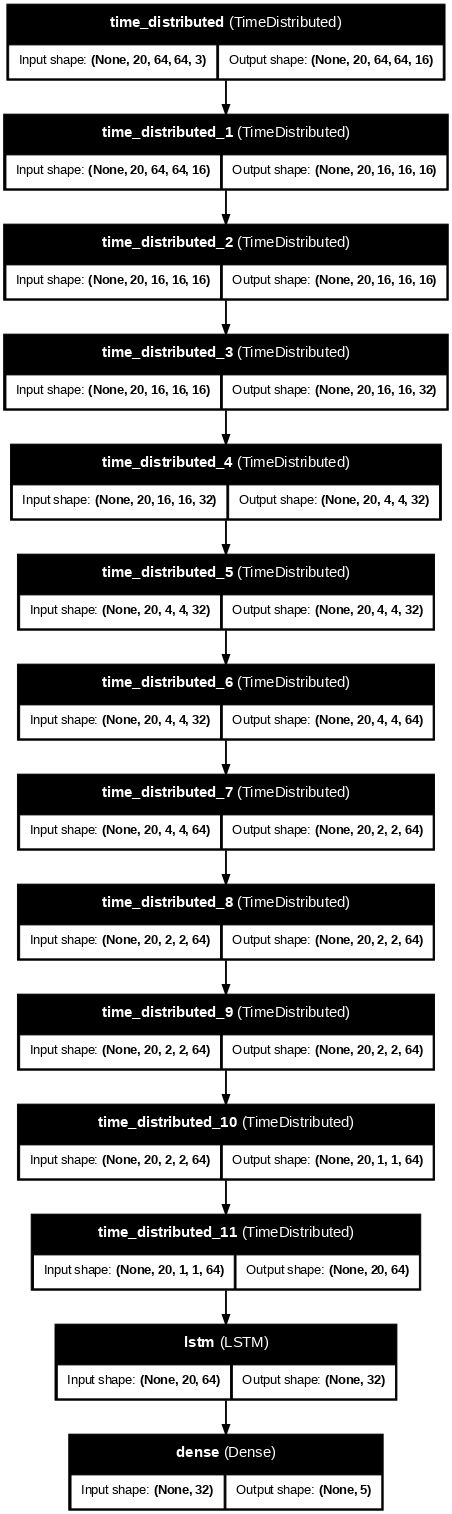

In [19]:
# Plotting the structure of the model
plot_model(LRCN_model, to_file = 'LRCN_model.png', show_shapes = True, show_layer_names = True, dpi = 66)

## Compiling and Training the model

In [20]:
#Compiling and Training
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 582ms/step - accuracy: 0.2462 - loss: 1.6213 - val_accuracy: 0.3774 - val_loss: 1.5236
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 87s 634ms/step - accuracy: 0.3850 - loss: 1.4220 - val_accuracy: 0.4434 - val_loss: 1.2884
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 68s 508ms/step - accuracy: 0.4749 - loss: 1.2755 - val_accuracy: 0.5189 - val_loss: 1.2582
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 84s 526ms/step - accuracy: 0.5001 - loss: 1.2137 - val_accuracy: 0.5094 - val_loss: 1.3154
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 509ms/step - accuracy: 0.5142 - loss: 1.1849 - val_accuracy: 0.6321 - val_loss: 0.9342
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 519ms/step - accuracy: 0.6407 - loss: 0.9182 - val_accuracy: 0.7170 - val_loss: 0.7675
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 501ms/step - accuracy: 0.4277 - loss: 1.3436 - val_accuracy: 0.6321 - val_loss: 0.9935
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.6959 - loss: 0

## Evaluating the trained model

In [23]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.9381 - loss: 0.2794


In [24]:
# saving the model
LRCN_model.save('LRCN_Human_Activity_Recognition_System.h5')

# Model Accuracy and Loss Curves

In [25]:
def plot_metric(model_training_history, metric_name1, metric_name2, plot_name):
  metric_value1 = model_training_history.history[metric_name1]
  metric_value2 = model_training_history.history[metric_name2]

  epochs = range(len(metric_value1))

  plt.plot(epochs, metric_value1, 'blue', label = metric_name1)
  plt.plot(epochs, metric_value2, 'red', label = metric_name2)

  plt.title(str(plot_name))
  plt.legend()
  plt.show()

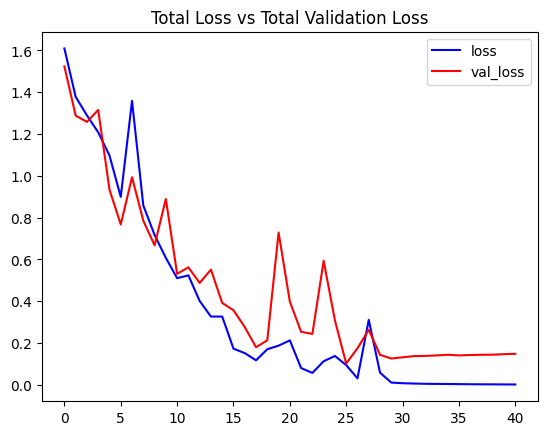

In [26]:
# Graph for Total Loss vs Validation Loss
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

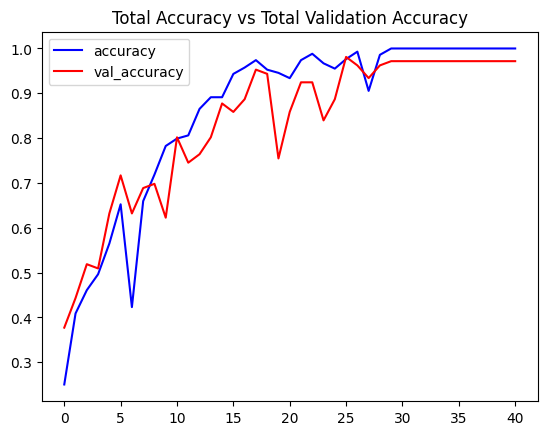

In [27]:
# Graph for Total Accuracy vs Validation Accuracy
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## Implementing functions to deal with youtube videos

In [32]:
'''
    The function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    It returns the title of the downloaded youtube video.
    '''
def download_youtube_videos(youtube_video_url, output_directory):
  import youtube_dl

  # Create a video object which contains useful information about the video.
  ydl_opts = {'quiet': True, 'verbose': True}  # Add verbose flag
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(youtube_video_url, download=False)
    video_title = info_dict.get('title', None)

     # Create a video object which contains useful information about the video.
  video = pafy.new(youtube_video_url)

  # Get the best available quality object for the video.
  video_best = video.getbest()

  # Construct the output file path.
  output_file_path = f'{output_directory}/{video_title}.mp4'

  # Download the youtube video at the best available quality and store it to the contructed path.
  video_best.download(filepath = output_file_path, quiet = True)

  return video_title

In [33]:
# Make the output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

In [ ]:
# downloading a video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

## Implementing Prediction Logic

In [ ]:
'''
  This function will perform action recognition on a video using the LRCN model.
  Args:
  video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
  output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
  SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
'''
def predict(video_file_path, output_file_path, SEQUENCE_LENGTH):

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (img_height, img_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = classes_list[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

## Testing the model

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()